In [1]:
from pathlib import Path
import numpy as np
from numpy.random import shuffle, seed
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import os
import gc

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from config import *
from lib.dl_modules import BatchGenerator
from lib.preprocess_modules import interpolate_airfoil, get_alfa_step
from nets.nn import *

In [2]:
# available resolutions
bitmap_outputs

[(1024, 4096), (256, 1024), (512, 512)]

In [3]:
bitmap_output_number = 2

# create dataset for 512x512
pkl_folder = str(bitmap_outputs[bitmap_output_number][0])+'x'+str(bitmap_outputs[bitmap_output_number][1])

# dataset config
incl_data = { 'Cl'  : True,
              'Cd'  : True,
              'Cm'  : True,
              'Cp'  : True,
              'd'   : True,
              'S'   : True,
              'Re'  : False,
              'alfa': False }

# count samples amount
samples_amount = len(os.listdir(Path(foils_bmp_path, pkl_folder)))
samples_amount = 138

# count data layers
n_data_layers = 0
for key in incl_data.keys():
    if incl_data[key]: n_data_layers+=1

In [4]:
print('Total samples: %i, layers in sample: %i.' % (samples_amount, n_data_layers))
print('Taking data from %s folder...' % pkl_folder)

X = np.zeros((samples_amount, n_data_layers, n_points_Re, n_points_alfa), dtype='float64')
y = np.zeros((samples_amount, bitmap_outputs[bitmap_output_number][0], bitmap_outputs[bitmap_output_number][1], 1), dtype='int8')

print('Created empty arrays: X(%s) and y(%s), import data...' % (X.shape, y.shape))

sample = 0

for fname in os.listdir(Path(foils_bmp_path, pkl_folder)): # сперва нужные профили
    
    if sample>samples_amount-1:break
        
    if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:        
        foil = load_pkl(Path(foils_pkl_path, fname))        
        ind_X=0        
        for i, key in enumerate(incl_data):
            if incl_data[key]:
                X[sample, ind_X, :, :] = foil['X'][i, :, :]
                ind_X+=1             
        y[sample, :, :, :] = np.expand_dims(load_pkl(Path(foils_bmp_path, pkl_folder, fname)), 2)
        sample+=1
        
for fname in os.listdir(Path(foils_bmp_path, pkl_folder)): #  потом все оставшиеся
    
    if sample>samples_amount-1:break
        
    if fname[:2].lower()  not in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht', 'X.', 'y.' ]:
        
        foil = load_pkl(Path(foils_pkl_path, fname))
        
        ind_X=0
        
        for i, key in enumerate(incl_data):
            if incl_data[key]:
                X[sample, ind_X, :, :] = foil['X'][i, :, :]
                ind_X+=1   
        y[sample, :, :, :] = np.expand_dims(load_pkl(Path(foils_bmp_path, pkl_folder, fname)), 2)
        sample+=1
        
# reshaping X 
X = X.reshape(samples_amount, n_data_layers*n_points_Re*n_points_alfa)

assert np.sum(np.isnan(X))==0, "NaNs in X"
assert np.sum(np.isnan(y))==0, "NaNs in y"

print('Saving...')

save_pkl(X, Path(dataset_folder, "X.pkl"))
save_pkl(y, Path(dataset_folder, "y.pkl"))

del X, y
gc.collect()

print('Done.')
print("Totally foils in arrays: %i" % (sample))

Total samples: 138, layers in sample: 6.
Taking data from 512x512 folder...
Created empty arrays: X((138, 6, 16, 32)) and y((138, 512, 512, 1)), import data...
Saving...
Done.
Totally foils in arrays: 138


In [4]:
X = load_pkl(Path(dataset_folder, 'X.pkl'))
y = load_pkl(Path(dataset_folder, 'y.pkl'))
X.shape, y.shape

((138, 3072), (138, 512, 512, 1))

In [5]:
all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

In [24]:
n_epochs=1000
batch_size=1
lr=1e-3
reg=0.001

model = light_param_net(X.shape[1], reg=reg, learning_rate=lr)
# model = flexi_net(input_vector_size=X.shape[1], output_size=y[0,:,:,0].shape, reg=reg, learning_rate=lr)
# model.load_weights(str(Path("./weights", r_name+'.h5')))#'initial_weights_300foils_04122020.h5')))

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')
print("Val_loss: %2.4e" % np.min(history.history['val_loss']))

Light parametrization net output shape: (None, 512, 512, 1)
Epoch 1/1000
102/103 [============================>.] - ETA: 0s - loss: 0.1782 - mse: 0.1782

KeyboardInterrupt: 

6 - ok
4 - 4.0961e-03
2 - Val_loss: 2.0237e-03


In [7]:
# save history and weights
from datetime import datetime
r_name = (str(datetime.now())[:16]).replace(':','-')
model.save_weights(str(Path(weights_path, r_name+'.h5')))
save_pkl(history.history, Path(weights_path, r_name+'.pkl'))

512x512
138:
16: Val_loss: 2.1742e-03
8: Val_loss: 1.6951e-03
4: Val_loss: 2.0985e-03

In [9]:
test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)
model = light_param_net(X.shape[1], reg=1, learning_rate=1e-5)
model.load_weights(str(Path("./weights", '2020-12-26 10-56.h5')))

Light parametrization net output shape: (None, 512, 512, 1)


In [15]:
# model.save(Path("./weights", '512x512.h5'),include_optimizer=True)

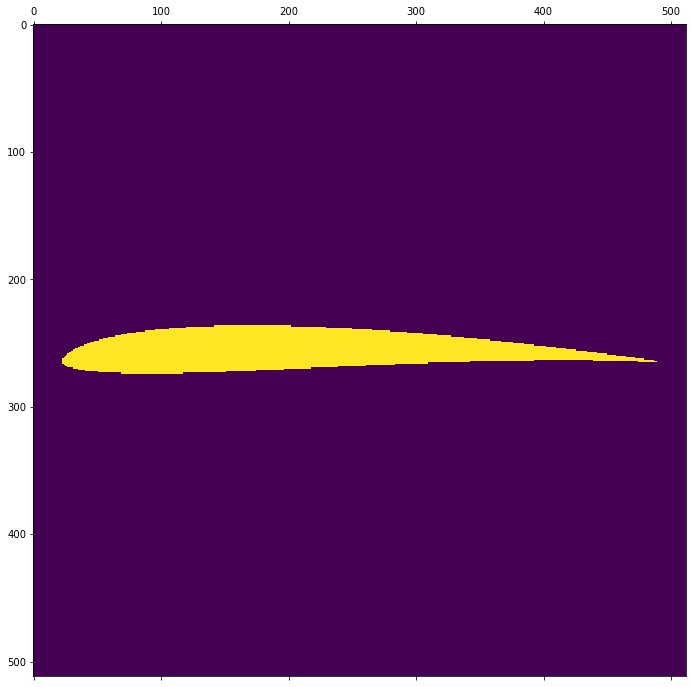

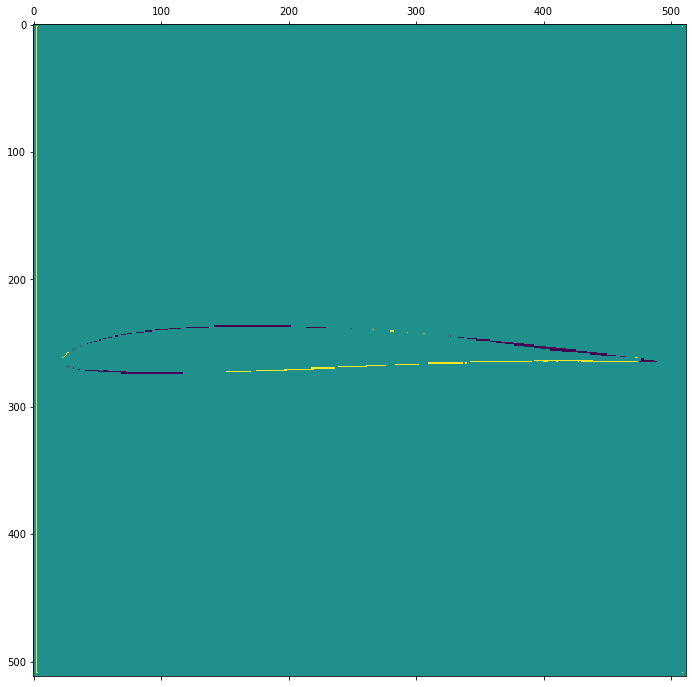

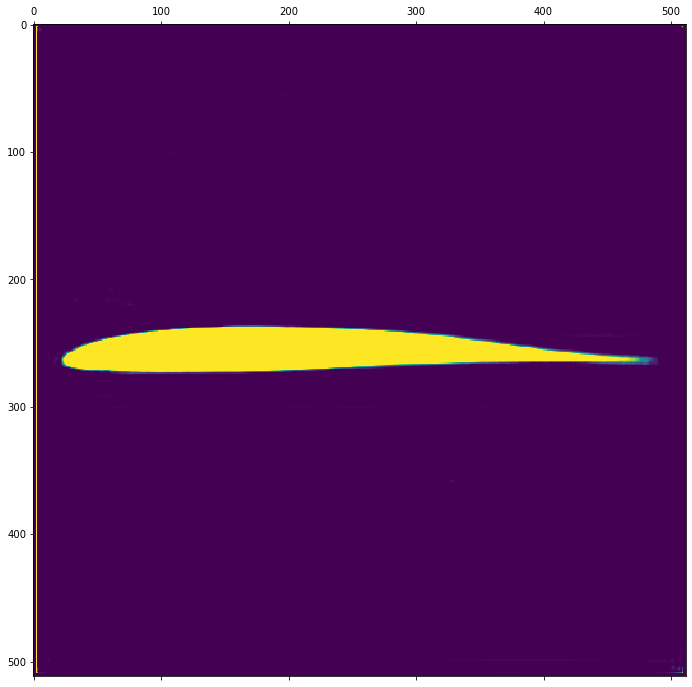

In [18]:
X_test, y_test = test_generator[11]
X_test = np.expand_dims(X_test[0], 0)
y_test = np.expand_dims(y_test[0], 0)

y_pred = model.predict(X_test)
# plt.figure(figsize=(12,12))
# plt.matshow(y_test[0,:,:,0],0)
plt.figure(figsize=(12,12))
plt.matshow(y_test[0,:,:,0],0)
plt.figure(figsize=(12,12))
plt.matshow((np.round(y_pred[0,:,:,0])-y_test[0,:,:,0]),0)
plt.figure(figsize=(12,12))
plt.matshow(y_pred[0,:,:,0],0)

In [ ]:
raise Exception

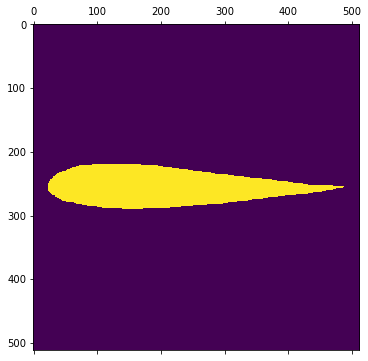

In [12]:
y = np.round(y_pred)[0, :, :, 0]
plt.figure(figsize=(16,6))
plt.matshow(y,0)

In [13]:
# ищем координаты

# сначала определим координаты начала и конца оси профиля

for x_nose in range(y.shape[1]):
    res = find_first_and_last_1_position(y[:, x_nose])
    if res!=-1:
        y_nose_top, y_nose_bot = res
        break
        
for x_tail in range(y.shape[1]-1,0,-1):
    res = find_first_and_last_1_position(y[:, x_tail])
    if res!=-1:
        y_tail_top, y_tail_bot = res
        break

if y_nose_top!=y_nose_bot: # ставим точку в середине носика, пригодится для красивой аппроксимации
    y_nose = int(np.average((y_nose_top, y_nose_bot)))
    y[y_nose,x_nose-1]=1
    x_nose-=1

if y_tail_top!=y_tail_bot: # а на хвостике не ставим и вообще хз чё делаем - к Димке
    pass
#     y_tail = int(np.average((y_tail_top, y_tail_bot)))
# else:
#     y_tail = y_tail_top
    
x_nose, y_nose, x_tail

(22, 257, 486)

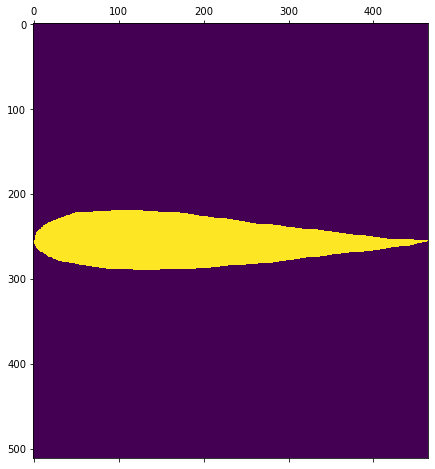

In [14]:

plt.figure(figsize=(24,8))
plt.matshow(y[:],0)

In [15]:
foil_x_top = (np.arange(y.shape[1])).tolist(); foil_x_top.reverse()
foil_x_bot = foil_x_top.copy() #foil_x[:-1]; x2.reverse() ; foil_x.extend(x2)

In [16]:
foil_y_top=[]
foil_y_bot=[]
for x in foil_x_top:
    if find_first_and_last_1_position(y[:, x])==-1: raise Exception
    y_t, y_b = find_first_and_last_1_position(y[:, x])
    foil_y_top.append(y_nose - y_t)
    foil_y_bot.append(y_nose - y_b)
foil_x_bot = foil_x_bot[:-1]
foil_x_bot.reverse()
foil_y_bot = foil_y_bot[:-1]
foil_y_bot.reverse()
foil_x_top.extend(foil_x_bot)
foil_y_top.extend(foil_y_bot)
foil_x = np.array(foil_x_top)/(y.shape[1]-1)
foil_y = np.array(foil_y_top)/(y.shape[1]-1)
foil_x.shape, foil_y.shape

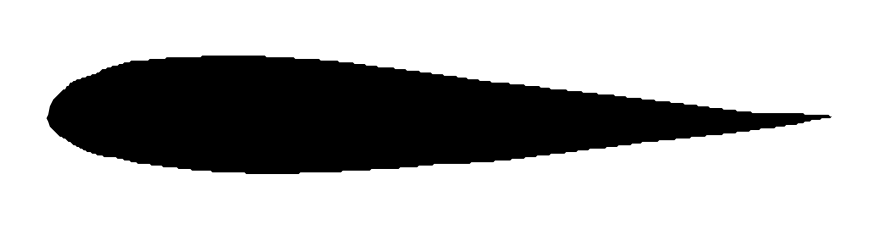

In [19]:
fig = plt.figure(figsize=(12,3),  frameon=False)
canvas = FigureCanvasAgg(fig)
ax = fig.add_axes([0.,0.,1.,1.])
ax.fill(foil_x, foil_y, 'black')
ax.axis('equal');
ax.axis('off');
s, (width, height) = canvas.print_to_buffer()

In [28]:
f_x, f_y = interpolate_airfoil(foil_x, foil_y, 256)

In [29]:
# set list of Re's
Re = np.linspace(re_min, re_max, n_points_Re).astype(int)
# get list of alfas and alfa step
alfa_step, alfas = get_alfa_step(alfa_min, alfa_max, n_points_alfa)

current_foil = Airfoil(f_x, f_y)
xf = XFoil()
xf.airfoil = current_foil
xf.max_iter = xfoil_max_iterations
for num in range(16):

    xf.Re = Re[num]        
    a, cl, cd, cm, cp = xf.aseq(alfa_min, alfa_max, alfa_step)
    raise Exception

Exception: 

In [31]:
cd

array([0.02837718, 0.02839214,        nan, 0.02836622, 0.02817133,
       0.02833435, 0.02826537, 0.02814429,        nan, 0.02774858,
       0.02756903, 0.02694843, 0.02696838, 0.02691632, 0.02691655,
       0.02713087, 0.02756391, 0.02802133, 0.02832558, 0.02898849,
       0.02910685, 0.03026072, 0.0305083 , 0.03105625, 0.03270565,
       0.0311233 , 0.0314392 , 0.03160494, 0.03249761, 0.03365809,
       0.03503241, 0.03579408])

In [4]:
xf = XFoil()

OSError: [WinError 193] %1 is not a valid Win32 application

In [23]:
import config


In [24]:
config.Re

AttributeError: module 'config' has no attribute 'Re'

In [255]:
f_x

array([ 1.00000000e+00,  9.78822842e-01,  9.56628964e-01,  9.34466611e-01,
        9.11833094e-01,  8.89197903e-01,  8.65163451e-01,  8.43471751e-01,
        8.20380303e-01,  7.97399321e-01,  7.73751246e-01,  7.51108000e-01,
        7.28928454e-01,  7.04979917e-01,  6.81836347e-01,  6.57839994e-01,
        6.34746949e-01,  6.11204402e-01,  5.87628664e-01,  5.64092901e-01,
        5.40558285e-01,  5.16556265e-01,  4.92554244e-01,  4.69463582e-01,
        4.45473249e-01,  4.21003857e-01,  3.96546143e-01,  3.73927724e-01,
        3.50364841e-01,  3.27732220e-01,  3.03727829e-01,  2.80181480e-01,
        2.56635184e-01,  2.33090633e-01,  2.09540389e-01,  1.85995122e-01,
        1.62905375e-01,  1.40270285e-01,  1.18092448e-01,  9.81206170e-02,
        7.50923075e-02,  5.48236153e-02,  3.34411074e-02,  1.24792319e-02,
       -9.65488169e-04, -3.81271181e-03, -1.58921242e-03,  5.41915016e-03,
        1.69265161e-02,  3.26470255e-02,  5.22948185e-02,  7.55840352e-02,
        1.02228816e-01,  

In [225]:
c = np.array([a,b]).T

In [227]:
c.shape
c

array([[1, 4],
       [2, 5],
       [3, 6],
       [4, 4]])

In [131]:
xo = x.copy()
xo.reverse()
xo

[3, 2, 1]

In [132]:
x.extend(xo)

In [133]:
x

[1, 2, 3, 3, 2, 1]

In [113]:
x

[3, 2, 1]

In [60]:
ind = np.unravel_index(np.argmax(y[:,49]), y[:,49].shape)
ind

(147,)

In [84]:
x

153

In [21]:
xt = X_test.reshape(6,16,32)

In [23]:
xt[0,0,:] = [1]

array([-0.05936276, -0.01701933,  0.0171289 ,  0.0494599 ,  0.08075152,
        0.111234  ,  0.14099106,  0.17000559,  0.19828717,  0.22578268,
        0.25237799,  0.27791429,  0.30227628,  0.3253468 ,  0.35581368,
        0.45017675,  0.52773142,  0.5996455 ,  0.66019589,  0.71231872,
        0.74865282,  0.78221673,  0.81368822,  0.84336275,  0.87164384,
        0.89902073,  0.92604083,  0.95123965,  0.97374296,  0.98991495,
        1.00836194,  1.03475928])